Import data from Data Cleaning output

In [202]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix


pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [203]:
df = pd.read_csv("C:/Users/Owner/Desktop/AlaskaProject/Data/modeldata.csv")
df.columns

Index(['participant.code', 'question', 'choice_binary', 'rowA_', 'rowB_',
       'rowdiff', 'price_diff', 'price_diff_rel', 'legroom_diff',
       'bathroom_dist_diff', 'distance_', 'price_', 'colA_categorical_Aisle',
       'colA_categorical_Middle', 'colA_categorical_Window',
       'colB_categorical_Aisle', 'colB_categorical_Middle',
       'colB_categorical_Window', 'seatA_class_Bathroom',
       'seatA_class_Economy', 'seatA_class_ExitRow', 'seatA_class_First',
       'seatA_class_Premium', 'seatB_class_Bathroom', 'seatB_class_Economy',
       'seatB_class_ExitRow', 'seatB_class_First', 'seatB_class_Premium',
       'plane_sideA_Left', 'plane_sideA_Right', 'plane_sideB_Left',
       'plane_sideB_Right', 'time__Daytime', 'time__Red-eye',
       'flyerfreq_nonflyer', 'flyerfreq_typical', 'flyerfreq_frequent',
       'flyertype_leisure', 'flyertype_business', 'hours_short',
       'hours_typical', 'hours_long'],
      dtype='object')

Column Cleanup

In [204]:
df.drop(['participant.code','question'],inplace = True, axis = 1)
df.rename(columns={'time__Red-eye':'time_redeye'}, inplace=True)

Define variables and train/test split

In [205]:
df_train = df.sample(frac = 0.8)
df_test = df.drop(df_train.index)

Scale continuous variables

In [206]:
# Scaled Variables
#Legroom
#df_train["legroom_diff"] = preprocessing.scale(pd.to_numeric(df_train["legroom_diff"]))
#df_test["legroom_diff"] = preprocessing.scale(pd.to_numeric(df_test["legroom_diff"]))
#df["legroom_diff"] = preprocessing.scale(pd.to_numeric(df["legroom_diff"]))

#Variable Price
df_train["price_diff"] = preprocessing.scale(pd.to_numeric(df_train["price_diff"]))
df_test["price_diff"] = preprocessing.scale(pd.to_numeric(df_test["price_diff"]))
df["price_diff"] = preprocessing.scale(pd.to_numeric(df["price_diff"]))


Define Y and Features

In [207]:
# Define output variable
y_dftrain = df_train.choice_binary
# Drop output variable from dataset to form input vector
X_dftrain = df_train.drop('choice_binary', axis=1)

# Define output variable
y_dftest = df_test.choice_binary
# Drop output variable from dataset to form input vector
X_dftest = df_test.drop('choice_binary', axis=1)



Create Basic Logistic Regression with no interaction terms

In [208]:
import statsmodels.api as sm
logitmodel=sm.Logit(y_dftrain,X_dftrain)
logresult=logitmodel.fit()
print(logresult.summary2())

         Current function value: 0.504556
         Iterations: 35
                                      Results: Logit
Model:                        Logit                    Pseudo R-squared:         0.269    
Dependent Variable:           choice_binary            AIC:                      4887.6315
Date:                         2021-05-27 15:50         BIC:                      5068.8998
No. Observations:             4788                     Log-Likelihood:           -2415.8  
Df Model:                     27                       LL-Null:                  -3305.5  
Df Residuals:                 4760                     LLR p-value:              0.0000   
Converged:                    0.0000                   Scale:                    1.0000   
No. Iterations:               35.0000                                                     
------------------------------------------------------------------------------------------
                          Coef.     Std.Err.      z    P>|z|  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Create a baseline model based on seat features, excluding flight and passenger characteristics

In [261]:
import statsmodels.formula.api  as smf


baseline=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    +rowdiff
                    
                    +price_diff 
                    +legroom_diff
                    +price_diff_rel 
                    
                    +colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window
                    -colB_categorical_Middle : colA_categorical_Aisle

                    +seatB_class_Economy : seatA_class_Bathroom 
                    +seatB_class_Bathroom : seatA_class_Economy 
                    +seatB_class_ExitRow : seatA_class_Economy
                    +seatB_class_Premium : seatA_class_ExitRow
                    +seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train)
                    

baselineresult=baseline.fit( maxiter = 500)

print(baselineresult.summary2())

Optimization terminated successfully.
         Current function value: 0.510108
         Iterations 7
                                         Results: Logit
Model:                          Logit                      Pseudo R-squared:           0.261    
Dependent Variable:             choice_binary              AIC:                        4922.7912
Date:                           2021-05-27 16:09           BIC:                        5045.7947
No. Observations:               4788                       Log-Likelihood:             -2442.4  
Df Model:                       18                         LL-Null:                    -3305.5  
Df Residuals:                   4769                       LLR p-value:                0.0000   
Converged:                      1.0000                     Scale:                      1.0000   
No. Iterations:                 7.0000                                                          
------------------------------------------------------------------

In [243]:
feature_names = logresult2.params.index
coefficients = logresult2.params.values

coefs = pd.DataFrame({
    'coef': coefficients,
    'odds ratio': np.exp(logresult2.params.values),
    'pvalue': logresult2.pvalues,
}).sort_values(by='odds ratio', ascending=False)
coefs

,coef,odds ratio,pvalue
colB_categorical_Middle:colA_categorical_Window,3.06831,21.50551,0.00000
seatB_class_Bathroom:seatA_class_Economy,1.06642,2.90496,0.00000
colB_categorical_Aisle:colA_categorical_Window,0.51425,1.67238,0.00038
Intercept,0.20604,1.22880,0.01799
legroom_diff,0.12318,1.13109,0.05136
seatB_class_Economy:seatA_class_First,-0.01899,0.98119,0.95947
rowA_:time_redeye,-0.02396,0.97632,0.00000
colB_categorical_Window:colA_categorical_Aisle,-0.03218,0.96833,0.89307
seatB_class_ExitRow:seatA_class_Economy,-0.32287,0.72407,0.05432
seatB_class_First:seatA_class_Premium,-0.52156,0.59360,0.02155


Check the Confusion Matrix

In [244]:
predicted_output = logresult2.predict(df_test)
predicted_output

5      0.37832
10     0.16324
15     0.29776
22     0.08189
24     0.93734
         ...  
5949   0.21285
5960   0.56932
5971   0.25822
5975   0.15150
5980   0.27915
Length: 1197, dtype: float64

<AxesSubplot:>

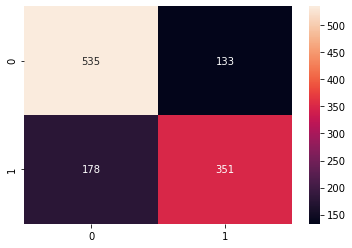

In [245]:
pred = np.array(logresult2.predict(df_test) > 0.5, dtype=float)
confmatrix = np.histogram2d(y_dftest, pred, bins=2)[0]
sns.heatmap(confmatrix, annot = True, fmt='g')

In [246]:
TN = confmatrix[0,0]
TP = confmatrix[1,1]
FN = confmatrix[1,0]
FP = confmatrix[0,1]

correct = TN+TP
incorrect = FN+FP

accuracy = correct/(correct+incorrect)
accuracy

0.7401837928153717

In [247]:
import statsmodels.formula.api  as smf


redeye=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    -rowdiff
                    
                    -price_diff
                    +legroom_diff
                    +price_diff_rel 
                    
                    -colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window
                    -colB_categorical_Middle : colA_categorical_Aisle

                    +seatB_class_Economy : seatA_class_Bathroom 
                    +seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    +seatB_class_Premium : seatA_class_ExitRow
                    -seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('time_redeye == 1'))
                    

redeyeresult=redeye.fit( maxiter = 500)

print(redresult.summary2())

Optimization terminated successfully.
         Current function value: 0.504386
         Iterations 7
                                        Results: Logit
Model:                         Logit                     Pseudo R-squared:          0.268      
Dependent Variable:            choice_binary             AIC:                       2495.4840  
Date:                          2021-05-27 16:01          BIC:                       2576.7378  
No. Observations:              2450                      Log-Likelihood:            -1233.7    
Df Model:                      13                        LL-Null:                   -1684.6    
Df Residuals:                  2436                      LLR p-value:               2.1767e-184
Converged:                     1.0000                    Scale:                     1.0000     
No. Iterations:                7.0000                                                          
---------------------------------------------------------------------------

In [193]:
import statsmodels.formula.api  as smf


business=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    +rowdiff
                    
                    -price_diff 
                    -legroom_diff
                    +price_diff_rel 
                    
                    -colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window
                    -colB_categorical_Middle : colA_categorical_Aisle

                    +seatB_class_Economy : seatA_class_Bathroom 
                    +seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    -seatB_class_Premium : seatA_class_ExitRow
                    +seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('flyertype_business == 1'))
                    

businessresult=business.fit( maxiter = 500)

print(businessresult.summary2())

Optimization terminated successfully.
         Current function value: 0.475125
         Iterations 8
                                        Results: Logit
Model:                        Logit                      Pseudo R-squared:           0.312     
Dependent Variable:           choice_binary              AIC:                        846.1657  
Date:                         2021-05-27 15:41           BIC:                        912.7790  
No. Observations:             861                        Log-Likelihood:             -409.08   
Df Model:                     13                         LL-Null:                    -594.34   
Df Residuals:                 847                        LLR p-value:                3.7049e-71
Converged:                    1.0000                     Scale:                      1.0000    
No. Iterations:               8.0000                                                           
---------------------------------------------------------------------------

In [201]:
import statsmodels.formula.api  as smf


frequent=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    +rowdiff
                    
                    -price_diff 
                    -legroom_diff
                    +price_diff_rel 
                    
                    +colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    -colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window
                    -colB_categorical_Middle : colA_categorical_Aisle

                    +seatB_class_Economy : seatA_class_Bathroom 
                    -seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    -seatB_class_Premium : seatA_class_ExitRow
                    +seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('flyerfreq_frequent == 1'))
                    

frequentresult=frequent.fit( maxiter = 500)

print(frequentresult.summary2())

Optimization terminated successfully.
         Current function value: 0.498943
         Iterations 7
                                         Results: Logit
Model:                        Logit                      Pseudo R-squared:           0.279      
Dependent Variable:           choice_binary              AIC:                        2191.4148  
Date:                         2021-05-27 15:42           BIC:                        2265.2870  
No. Observations:             2170                       Log-Likelihood:             -1082.7    
Df Model:                     12                         LL-Null:                    -1502.1    
Df Residuals:                 2157                       LLR p-value:                7.9856e-172
Converged:                    1.0000                     Scale:                      1.0000     
No. Iterations:               7.0000                                                            
------------------------------------------------------------------

In [230]:
import statsmodels.formula.api  as smf


short=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    +rowdiff
                    
                    +price_diff 
                    -legroom_diff
                    -price_diff_rel 
                    
                    -colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    -colB_categorical_Aisle : colA_categorical_Middle 
                    -colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window
                    -colB_categorical_Middle : colA_categorical_Aisle

                    -seatB_class_Economy : seatA_class_Bathroom 
                    -seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    -seatB_class_Premium : seatA_class_ExitRow
                    +seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    -seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('hours_short == 1'))
                    

shortresult=short.fit( maxiter = 500)

print(shortresult.summary2())

Optimization terminated successfully.
         Current function value: 0.474656
         Iterations 7
                                        Results: Logit
Model:                        Logit                      Pseudo R-squared:           0.310     
Dependent Variable:           choice_binary              AIC:                        777.4498  
Date:                         2021-05-27 15:55           BIC:                        819.6113  
No. Observations:             800                        Log-Likelihood:             -379.72   
Df Model:                     8                          LL-Null:                    -550.10   
Df Residuals:                 791                        LLR p-value:                8.5300e-69
Converged:                    1.0000                     Scale:                      1.0000    
No. Iterations:               7.0000                                                           
---------------------------------------------------------------------------

In [236]:
import statsmodels.formula.api  as smf


long=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    +rowdiff
                    
                    +price_diff 
                    -legroom_diff
                    -price_diff_rel 
                    
                    +colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window
                    -colB_categorical_Middle : colA_categorical_Aisle

                    +seatB_class_Economy : seatA_class_Bathroom 
                    +seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    -seatB_class_Premium : seatA_class_ExitRow
                    +seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('hours_long == 1'))
                    

longresult=long.fit( maxiter = 500)

print(longresult.summary2())

Optimization terminated successfully.
         Current function value: 0.513316
         Iterations 7
                                        Results: Logit
Model:                         Logit                     Pseudo R-squared:          0.258      
Dependent Variable:            choice_binary             AIC:                       1541.2015  
Date:                          2021-05-27 15:58          BIC:                       1620.6171  
No. Observations:              1472                      Log-Likelihood:            -755.60    
Df Model:                      14                        LL-Null:                   -1018.5    
Df Residuals:                  1457                      LLR p-value:               3.2821e-103
Converged:                     1.0000                    Scale:                     1.0000     
No. Iterations:                7.0000                                                          
---------------------------------------------------------------------------

In [277]:
feature_names = baselineresult.params.index
coefficients = baselineresult.params.values

coefs = pd.DataFrame({
    'feature' : baselineresult.params.index,
    'basecoef': baselineresult.params.values,
    'redeyecoef': redeyeresult.params.values,

})
coefs


ValueError: arrays must all be same length